In [1]:
import os
os.chdir('..')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from collections import defaultdict
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15.0, 7.0)
sns.set(style="ticks")

In [2]:
import matplotlib
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (15.0, 7.0)

In [3]:
from com.lc_helpers import *

In [4]:
def plot_regression(training_df, y, x, m_t=-10.0, grades=['A', 'B', 'C', 'D', 'E', 'F', 'G'], xlim=[-0.1, 1.1]):
    df = training_df
    
    model_vs_actual = pd.concat([df.pipe(df_ols, y=y, x=x).y_predict, df[y]], axis=1, keys=['model', 'actual'])
    
    model_vs_actual[model_vs_actual['model'] > m_t].plot.scatter('actual', 'model', sharex=False, title='{}: model vs actual'.format(y))
    plt.show()
    
    model_vs_actual[model_vs_actual['model'] > m_t].plot.hexbin('actual', 'model', sharex=False, title='{}: model vs actual'.format(y))
    plt.xlim(xlim)
    plt.show()
    
    model_vs_actual['actual'].plot.hist(bins=100, title='{}: actual'.format(y))
    plt.xlim(xlim)
    plt.show()
    
    return model_vs_actual

In [5]:
def plot_test_training(testing_df, training_df, y, x, m_t=0.0, grades=['A', 'B', 'C', 'D', 'E', 'F', 'G'], xlim=[-0.1, 1.1]):
    reg_test_df = testing_df
    reg_train_betas = training_df.pipe(df_ols, y=y, x=xs).beta
    test_betas = pd.concat([reg_test_df[column] * reg_train_betas[column] for column in reg_train_betas.index if column in reg_test_df], axis=1)
    model_vs_actual = pd.concat([test_betas.sum(axis=1) + reg_train_betas['intercept'], reg_test_df[y]], axis=1, keys=['model', 'actual'])
    model_vs_actual[model_vs_actual['model'] > m_t].plot.scatter('actual', 'model', sharex=False, title='{}: model vs actual'.format(y))
    plt.show()
    
    model_vs_actual[model_vs_actual['model'] > m_t].plot.hexbin('actual', 'model', sharex=False, title='{}: model vs actual'.format(y))
    plt.xlim(xlim)
    plt.show()
    
    model_vs_actual['actual'].plot.hist(bins=100, title='{} actual'.format(y))
    plt.xlim(xlim)
    plt.show()
    
    return model_vs_actual

In [6]:
training = pd.read_csv(get_db_folder()['testing'])
testing = pd.read_csv(get_db_folder()['testing3'])

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
training = training.pipe(make_df_numeric, fix_nans=True)

In [8]:
testing = testing.pipe(make_df_numeric, fix_nans=True)

In [9]:
# choose which grades to regress
grades = [
    'A',
    'B',
    'C',
    'D', 
    'E', 
    'F', 
    'G'
]

In [10]:
# pick the x and y variables to use in the regression
xs = [
    'dti', 
    'int_rate',
    'loan_amnt', 
    'mths_since_last_delinq', 
    'mths_since_last_record',
     'mths_since_last_major_derog',
    'revol_bal',
    'revol_util',
    'annual_inc',
    'open_acc',
    'total_acc',
    'pub_rec',
    #'grade_int',
    'credit_history',
    'emp_length',
    'verified',
    'own_home',
    'installment',
    'delinq_2yrs',
    'inq_last_6mths',
    'joint_account'
] + purposes + states

y = [
    #'defaulted',
    # 'profit',
    'annualized_profit'
]

# training.loc[:, xs + y]

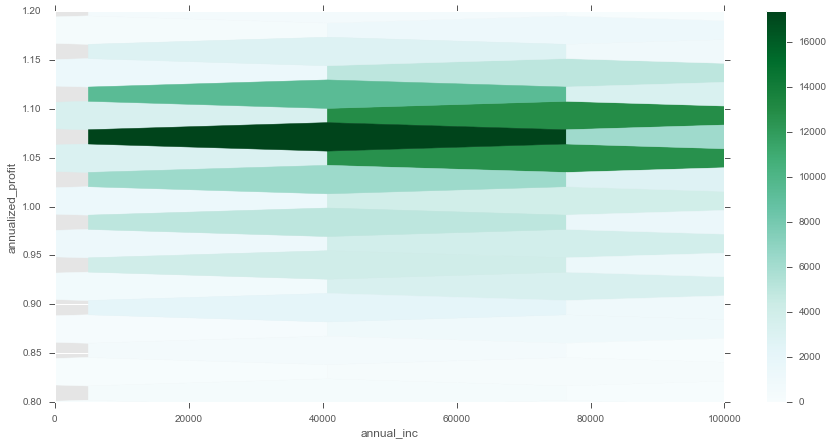

In [15]:
training.plot.hexbin('annual_inc', 'annualized_profit', xlim=[0, 100000], ylim=[0.8, 1.2], sharex=False)
#.pipe(plot_test_training, testing.query('grade == "F"'), y=y[0], x=xs,xlim=[0.8, 1.4])
#training.query('grade == "D"')['int_rate'].perce

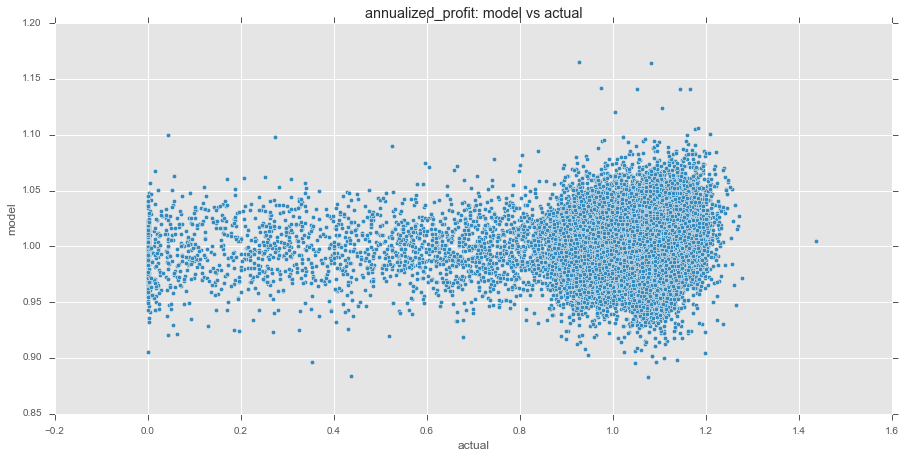

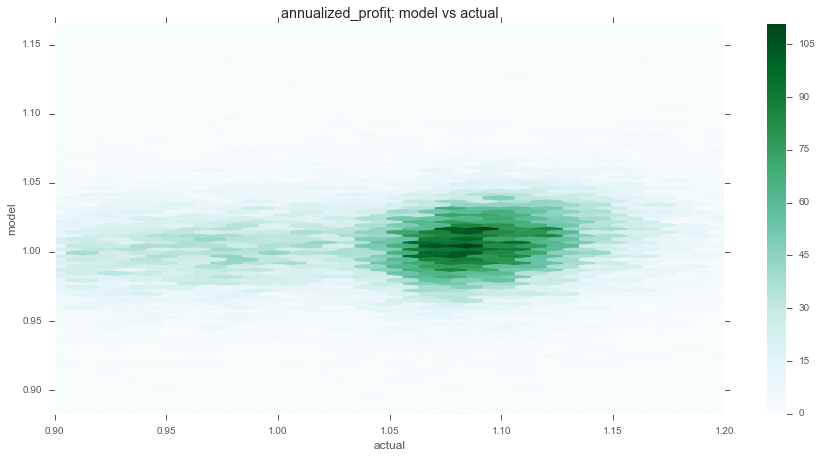

ValueError: The first argument of bincount must be non-negative

In [19]:
# plot the training model
model_vs_actual_train = plot_regression(training, y[0], xs, m_t=0, grades=grades, xlim=[0.9, 1.2])

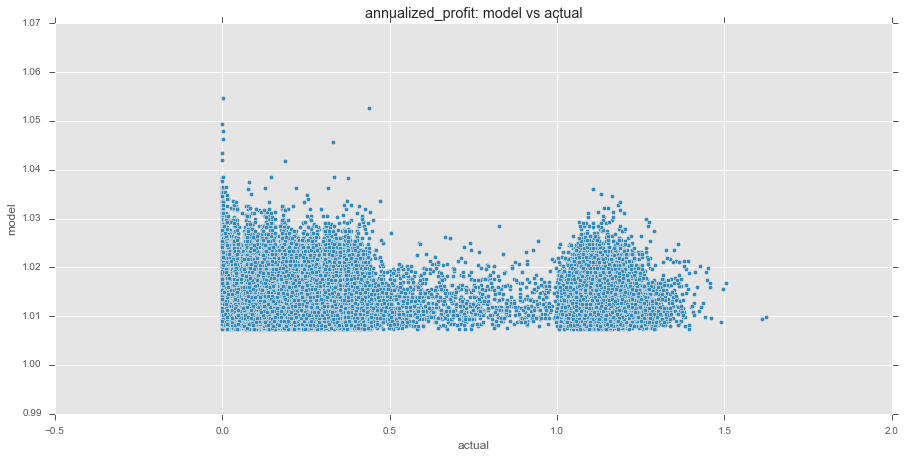

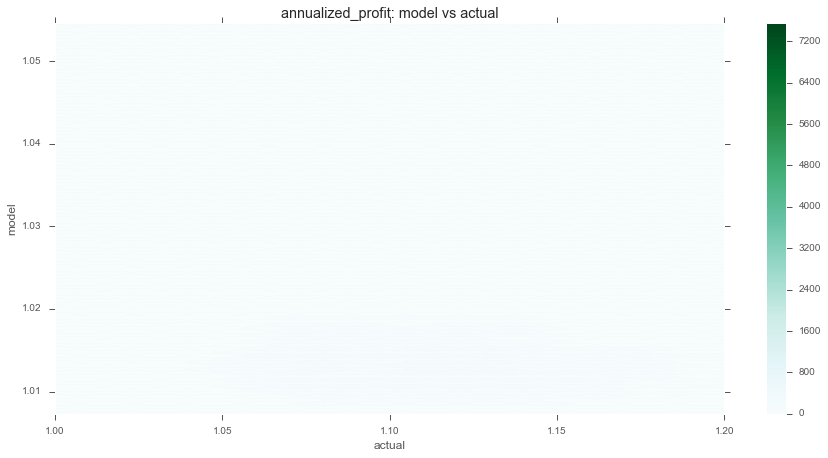

ValueError: The first argument of bincount must be non-negative

In [13]:
# apply the training model to the testing data
model_vs_actual_test = plot_test_training(testing, training, y[0], xs, m_t=0.0, xlim=[1.0, 1.2], grades=grades)

In [ ]:
model_vs_actual_train.head(5)

In [ ]:
model_vs_actual_test.head(5)